In [1]:
from collections import OrderedDict
import json
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('..')

from dropout.penalties import Penalty1D, FPenalty1D, OmegaPenalty1D, LpPenalty1D, LogSumPenalty1D, MCPPenalty1D, StandoutPenalty1D, VarDropPenalty1D, VarDropPenaltyExact1D, L0LouizosPenalty1D, SeparablePenalty

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}\renewcommand{\rmdefault}{ptm}\renewcommand{\sfdefault}{phv}')
plt.rcParams['figure.figsize'] = [5.5, 2.0]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

pattern_cycle = [
    '-',
    '--',
    ':',
    '-.',
    (0, (4, 1, 1, 1, 1, 1)),
    (0, (10, 1, 3, 1)),
    (0, (3, 1, 1, 1)),
    (4, (2, 1, 4, 1))
]

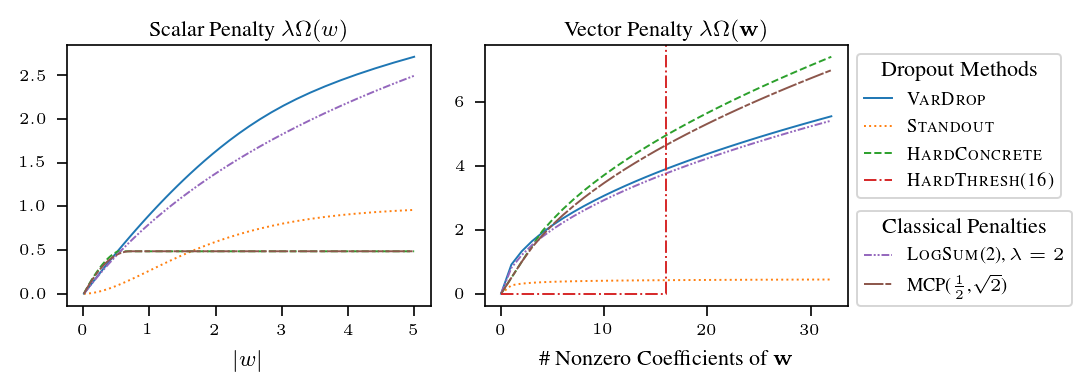

In [3]:
ws = np.logspace(-2, np.log10(5), 100)
d = 32
k_iht = 16

penalties = OrderedDict([
    (r'\textsc{VarDrop}', (VarDropPenaltyExact1D(), 1, 0, 0, True)),
    (r'\textsc{Standout}', (StandoutPenalty1D(1), 1, 1, 2, True)),
    (r'\textsc{HardConcrete}', (L0LouizosPenalty1D(1), 1, 2, 1, True)),
    (r'\textsc{LogSum}(2), $\lambda=2$', (LogSumPenalty1D(2), 2, 4, 4, False)),
    (r'MCP($\frac{1}{2}$,$\sqrt{2}$)', (MCPPenalty1D(0.5, np.sqrt(2)), np.sqrt(2), 5, 5, False)),
])

plt.figure(dpi=200)
plt.subplot(1, 2, 1)



for i, (name, (penalty, lamda, color, pattern, is_dropout)) in enumerate(penalties.items()):
    min_val = penalty(ws[0])
    plt.plot(ws, [lamda * (penalty(x) - min_val) for x in ws], color=color_cycle[color], ls=pattern_cycle[pattern], label=name)

#plt.legend()
plt.title(r'Scalar Penalty $\lambda \Omega(w) $')
plt.xlabel('$|w|$')

plt.subplot(1, 2, 2)

dropout_handles = []
classical_handles = []

for i, (name, (penalty, lamda, color, pattern, is_dropout)) in enumerate(penalties.items()):
    
    if isinstance(penalty, Penalty1D):
        penalty = SeparablePenalty(penalty)
    
    omegas = np.zeros(d + 1)
    
    for k in range(d + 1):
        
        x = np.zeros(d)
        x[:k] = 1 / np.sqrt(k + 1e-3)
        
        omegas[k] = penalty(x)
        
    min_val = min(omegas)
    
    h = plt.plot(lamda * (omegas - min_val), color=color_cycle[color], ls=pattern_cycle[pattern], label=name)
    if is_dropout:
        dropout_handles += h
    else:
        classical_handles += h

ylim = plt.gca().get_ylim()
    
omegas_iht = np.zeros(d + 1)
omegas_iht[k_iht+1:] = 100
h = plt.step(np.arange(d + 1), omegas_iht, color=color_cycle[3], ls=pattern_cycle[3], label=r'\textsc{HardThresh(%d)' % k_iht)
dropout_handles += h

plt.ylim(*ylim)
plt.title(r'Vector Penalty $\lambda \Omega(\mathbf{w})$')
leg = plt.legend(handles=dropout_handles, bbox_to_anchor=(1, 1), loc='upper left', title='Dropout Methods', fontsize='small')
plt.gca().add_artist(leg)
plt.legend(handles=classical_handles, bbox_to_anchor=(1, 0.4), loc='upper left', title='Classical Penalties', fontsize='small')
plt.xlabel(r'\# Nonzero Coefficients of $\mathbf{w}$')

plt.tight_layout()

plt.savefig('penalties.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [4]:
names = [
    'VariationalDropout',
    'VariationalDropoutNoAR',
    'VariationalDropoutNoReparam',
    'EtaTrick',
    'ProxSGD',
    'Tikhonov',
    'LogSum'
]
histories = OrderedDict()

for name in names:
    
    fn = '%s_history.json' % name
    
    name = fn.split('_')[0]    
    with open(os.path.join('nets', fn), 'r') as f:
        histories[name] = json.load(f)

    print(name)

VariationalDropout
VariationalDropoutNoAR
VariationalDropoutNoReparam
EtaTrick
ProxSGD
Tikhonov
LogSum


In [5]:
name_map = {
    'VariationalDropout': 'VarDrop+LR+AR',
    'VariationalDropoutNoAR': 'VarDrop+LR',
    'VariationalDropoutNoReparam': 'VarDrop',
    'GaussianDropout': 'GaussDrop',
    'ScaledBernoulliDropout': 'AdaDrop',
    'ProxSGD': 'AdaProx',
    'EtaTrick': '$\eta$-Trick',
    'Tikhonov': 'AdaTikhonov',
    'LogSum': 'LogSum'
}

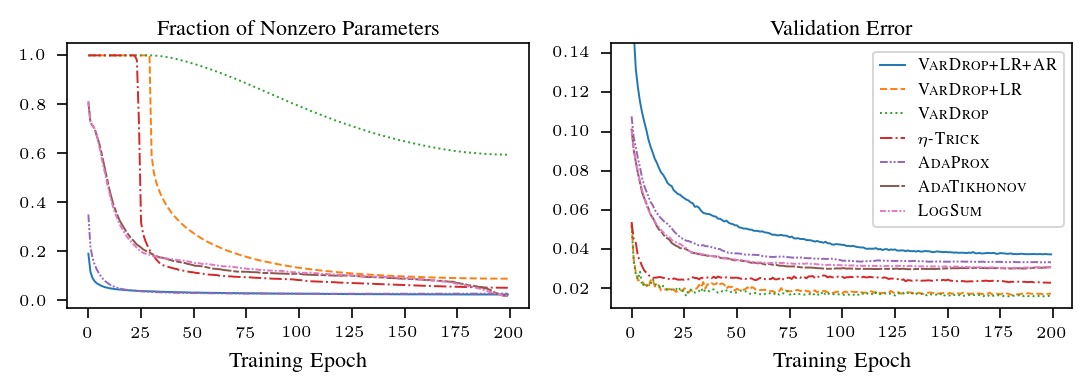

In [6]:
plt.figure(figsize=(5.5, 2), dpi=200)

def extract_from_history(history, key):
    return np.asarray([h[key] for h in history])

plt.subplot(1, 2, 1)

for i, (name, history) in enumerate(histories.items()):
    
    sparsity = extract_from_history(history, 'sparsity')
    plt.plot(1 - sparsity, ls=pattern_cycle[i % len(pattern_cycle)], label=name_map[name])

plt.title('Fraction of Nonzero Parameters')
plt.xlabel('Training Epoch')

plt.subplot(1, 2, 2)

for i, (name, history) in enumerate(histories.items()):
    
    sparsity = extract_from_history(history, 'valid_acc')
    plt.plot(1 - sparsity, ls=pattern_cycle[i % len(pattern_cycle)], label=r'\textsc{%s}' % name_map[name])

plt.legend()
plt.title('Validation Error')
plt.xlabel('Training Epoch')
plt.ylim(0.01, 0.145)

plt.tight_layout()

plt.savefig('lenet-300-100.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [7]:
names_accs_sparsities = [(name, history[-1]['test_acc'], history[-1]['sparsity']) for name, history in histories.items()]

print(r'      Method & Test error & Sparsity \\')
print('=============+============+=========')
for name, acc, sparsity in names_accs_sparsities:
    print(r'%13s & %g\%%      & %g \\' % (name_map[name], 100 * (1 - acc), 1 - sparsity))

      Method & Test error & Sparsity \\
=============+============+=========
VarDrop+LR+AR & 3.21\%      & 0.0237904 \\
   VarDrop+LR & 1.41\%      & 0.0884861 \\
      VarDrop & 1.54\%      & 0.594598 \\
 $\eta$-Trick & 2.16\%      & 0.0513373 \\
      AdaProx & 2.94\%      & 0.0275582 \\
  AdaTikhonov & 2.88\%      & 0.0182795 \\
       LogSum & 2.93\%      & 0.0189557 \\
